# Principal Components Analysis (PCA)

In [8]:
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.lda import LDA
import matplotlib.cm as cm

digits = load_digits()
data = digits.data

n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target

In [14]:
pca = PCA(n_components=10)
data_r = pca.fit(data).transform(data)

print('explained variance ratio (first two components): %s' %str(pca.explained_variance_ratio_))
print('sum of explained variance (first two components): %s' %str(sum(pca.explained_variance_ratio_)))

explained variance ratio (first two components): [ 0.14890594  0.13618771  0.11794594  0.08409979  0.05782415  0.0491691
  0.04315987  0.03661373  0.03353248  0.03078806]
sum of explained variance (first two components): 0.738226768846


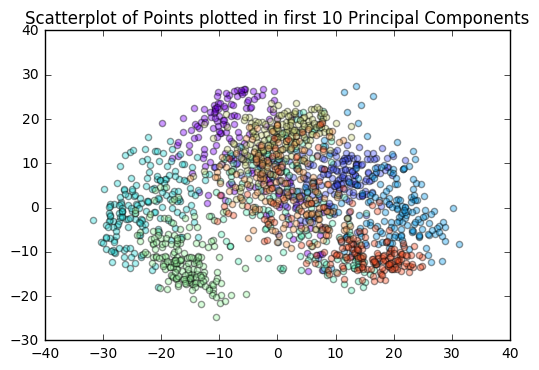

In [24]:
X = np.arange(10)
ys = [i+X+(i*X)**2 for i in range(10)]

plt.figure()
colors = cm.rainbow(np.linspace(0, 1, len(ys)))
for c, i, target_name in zip(colors, [1,2,3,4,5,6,7,8,9,10], labels):
    plt.scatter(data_r[labels == i, 0], data_r[labels == i, 1], c=c, alpha = 0.4)
    plt.legend()
    plt.title('Scatterplot of Points plotted in first 10 Principal Components')
plt.show()

# K-Means Clustering

In [62]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics

np.random.seed()

digits = load_digits()
data = scale(digits.data)

n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target

sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d" % (n_digits, n_samples, n_features))

print(79 * '_')
print('name      time inertia homo compl v-meas ARI silhouette')

def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('% 9s %.2fs %i %.3f %.3f %.3f %.3f %.3f'
     % (name, (time() - t0), estimator.inertia_,
       metrics.homogeneity_score(labels, estimator.labels_),
       metrics.completeness_score(labels, estimator.labels_),
       metrics.v_measure_score(labels, estimator.labels_),
       metrics.adjusted_rand_score(labels, estimator.labels_),
       metrics.silhouette_score(data, estimator.labels_, metric='euclidean', sample_size=sample_size)))
    
bench_k_means(KMeans(n_clusters=n_digits, init='k-means++', n_init=10), name="k-means++", data=data)
print(79 * '_')

n_digits: 10, 	 n_samples 1797, 	 n_features 64
_______________________________________________________________________________
name      time inertia homo compl v-meas ARI silhouette
k-means++ 0.30s 69671 0.681 0.720 0.700 0.571 0.146
_______________________________________________________________________________


#### Homogeneity Score
- a simple, zero-to-one bounded measure of the degree to which clusters contain only assignments of a given class.  A score of one indicates that all clusters contain measurements from a single class.
#### Completeness Score
- compliments the homogeneity score.  A similarly bounded measure of the extent to which all members of a given class are assigned to the same cluster.  
- As such, a completeness score and homogeneity score of one indicates a perfect clustering solution
#### Validity Measure (v-measure)
- is a harmonic mean of the homogeneity and completeness scores, which is exactly analagous to the F-measure for binary classification.  In essence, it provides a single, 0-1 scaled value to monitor both homogeneity and completeness.
#### Adjusted Rand Index (ARI)
- is a similarity measure that tracks the consensus between sets of assignments.  As applied to clustering, it measures the consensus between the true, pre-existing observation labels and the labels predicted as an output of the clustering algorithm.  The Rand index measures labeling similarity on a 0-1 bound scale, with one equaling perfect prediction labels.

The main challenge with all of the preceding performance measures as well as other similar measures (for example, Akaike's mutual information criterion) is that they require an understanding of the ground truth, that is, they require some or all of the data under inspection to be labeled.  If labels do not exist and cannot be generated, these measures won't work.  In practice, this is a pretty substantial drawback as very few datasets come prelabeled and the creation of labels can be time-consuming.

#### Silhouette Coefficient
- One option to measure the performance of a k-means clustering solution without labeled data is the Silhouette Coefficient.
- This is a measure of how well-defined the clusters within a model are.  The Silhouette Coefficient for a given data set is the mean of the coefficient for each sample.  The score is bounded between -1 and 1, with -1 indicating incorrect clustering, 1 indicating very dense clustering, and scores around 0 indicating overlapping clusters.

In [63]:
pca = PCA(n_components=n_digits,).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=10), name="PCA-based", data=data)

PCA-based 0.05s 71820 0.673 0.715 0.693 0.567 0.117


C:\Users\tim.latham\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\cluster\k_means_.py:821: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  n_jobs=self.n_jobs)


#### Elbow Method
- The elbow method is a very simple technique; for each instance of k, plot the percentage of explained variance agains k.  This typically leads to a plot that frequently looks like a bent arm

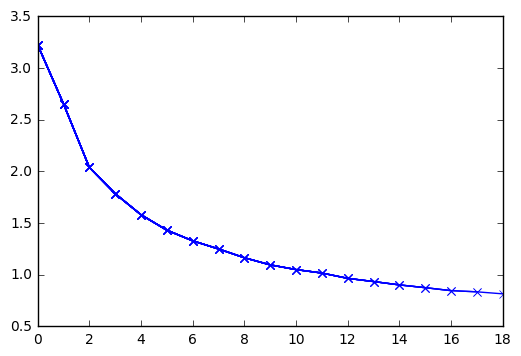

In [77]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

digits = load_digits()
data = scale(digits.data)

n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target

K = range(1,20)
explainedVariance = []
for k in K:
    reduced_data = PCA(n_components=2).fit_transform(data)
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=k)
    kmeans.fit(reduced_data)
    explainedVariance.append(sum(np.min(cdist(reduced_data, kmeans.cluster_centers_, 'euclidean'), axis=1))/data.shape[0])
    plt.plot(explainedVariance, 'bx-')
plt.show()
#print explainedVariance

#### v-fold cross-validation
- Splits the dataset into v parts.  One of the parts is set aside individually as a test set.  The model is trained against the training data, which is all parts except the test set.
    - Isn't this k-folds, not v-folds??

In [78]:
import numpy as np
from sklearn import cross_validation
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

digits = load_digits()
data = scale(digits.data)

n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target

kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=n_digits)
cv = cross_validation.ShuffleSplit(n_samples, n_iter=10, test_size=0.4, random_state=0)
scores = cross_validation.cross_val_score(kmeans, data, labels, cv=cv, scoring='adjusted_rand_score')
print(scores)
print(sum(scores)/cv.n_iter)

[ 0.41049514  0.47986593  0.38837626  0.52310018  0.50057969  0.49551069
  0.48282878  0.58057056  0.47202296  0.44612332]
0.477947350829


# Self-Organizing Maps (SOM)

The SOM algorithm involves iteration over many simple operations.  When applied at a smaller scale, it behaves similarly to k-means clustering.  At a larger scale, SOMs reveal the topology of complex datasets in a powerful way.

An SOM is made up of a grid (commonly rectangular or hexagonal) of nodes, where each node contains a weight vector that is of the same dimensionality as the input dataset.  The nodes may be initialized randomly, but an initialization that roughly approximates the distribution of the dataset will tend to train faster.

The algorithm iterates as observations are presented as input.  

## SOM code is in the code repository or on GitHub and is necessary to do the examples in the book :(